# **INITIALIZATION**

Import libraries.

In [12]:
# Library for reading and writing data to and from files
import os
# Library for numerical computing
import numpy as np
# Library for mathematical functions
import math
# Library for getting dictionaries from data structures
from collections import defaultdict
# Library to get fit models
from scipy.optimize import curve_fit
# Library to plot histograms
import matplotlib.pyplot as plt

Define paths.

In [13]:
# Dataset directory
corpus_directory='../Dataset/corpus2mw'

To iterate the reading procedure, get the names of the documents in the dataset.

In [14]:
# Get a list with the names of the documents
texts_names = os.listdir(corpus_directory)

Set the seed for reproducibility.

In [15]:
np.random.seed(55555555)

# **GET TOKENS**

First, define the special characters to be separated from each word.

In [16]:
# List of characters
specialchars = [';', ':', '!', '?', '<', '>', '&', ')', '(', ']', '[', ',', '.', '"', '%', '$ ', '=', '}', '{', '-', '_', '+', '*', '#', '@']

And define the function which separates the special characters from each word, assuming they can only be before or after each word.

In [17]:
def token(w):
    # Init the empty list of tokens
    res = []

    # If the length is 1, add the character whatever it is
    if len(w) == 1:
        res.append(w)
    
    # Otherwise (if it's at least two characters)
    else:
        # If the first character is special, add it to the list and remove it from the word
        if w[0] in specialchars:
            res.append(w[0])
            w = w[1:]
        
        # Now, if the length became 1 because of that, for the same reason as before, add the character whatever it is
        if len(w) == 1:
            res.append(w)
        # Otherwise (if it's at least two characters), both if I had removed the first or not
        # Check whether the last character is special
        elif w[-1] in specialchars:
            res.append(w[:-1])
            res.append(w[-1])
        # or not
        else:
            res.append(w)
        
    # Return the list of tokens
    return res

For each document, for each word (in each line), if either the last or the first character are specialchars, then split in multiple tokens.

In [18]:
corpus = []
corpus_lens = []

# For each document in the directory
for text in texts_names:

    # Init a temp empty list for the words in the current document
    words = []

    # Open the document
    with open(corpus_directory + '/' + text, 'r', errors='ignore') as file:

        # For each line
        for line in file:
            # For each word in the line
            for word in line.split():
                # Tokenize it
                aux = token(word)
                # And add each token to the list of words
                for t in aux:
                    words.append(t.lower())
    # Then append the list of tokens for the document in the corpus list
    corpus.append(words)
    corpus_lens.append(len(words))

corpus_len = len(corpus)

This way, the corpus is a list of documents, which are lists of tokens.

In [19]:
# Print length for each document
print(corpus_lens)
# And compute the overall number of words
num_of_words_in_corpus = sum(corpus_lens)
print("There are ", num_of_words_in_corpus, " words in the corpus")

[5955, 2028, 312, 680, 351, 2773, 1253, 286, 856, 510, 442, 1484, 445, 1246, 341, 619, 823, 529, 620, 749, 1145, 1014, 214, 165, 354, 524, 391, 1343, 289, 1228, 452, 225, 160, 374, 722, 1275, 846, 464, 748, 213, 155, 494, 246, 956, 402, 1482, 795, 510, 364, 1355, 154, 200, 1492, 233, 3206, 261, 619, 218, 910, 417, 657, 762, 219, 1305, 412, 929, 343, 314, 1676, 1315, 284, 1211, 1638, 769, 888, 1272, 1118, 456, 1541, 215, 404, 175, 414, 1056, 772, 919, 860, 1215, 753, 249, 4310, 139, 197, 256, 163, 290, 659, 1920, 548, 881, 1722, 333, 292, 2153, 233, 1501, 731, 268, 259, 1166, 401, 1044, 1540, 355, 3404, 498, 247, 818, 3268, 733, 373, 178, 704, 685, 1547, 280, 343, 206, 364, 2181, 643, 480, 783, 232, 619, 130, 194, 615, 559, 760, 417, 305, 252, 836, 176, 1402, 519, 706, 1233, 675, 489, 276, 202, 550, 163, 755, 4634, 277, 251, 355, 260, 442, 822, 338, 1857, 1677, 250, 584, 310, 472, 643, 723, 499, 229, 218, 194, 224, 180, 178, 334, 293, 462, 522, 245, 244, 137, 431, 566, 1371, 679, 426, 4

Define a function to get a list of words from a string with words separated with a space.

In [20]:
# Given a list of strings, it returns a string
# in which the substrings will be separated by ' '
def list_to_str(strings):
    # Init res as an empty string
    res = ""
    # For each character/string in the list
    for i in range(len(strings)):
        # Concatenate the string plus a space to res
        res += strings[i] + ' '
    # Then return everything besides the last space
    return res[:-1]

Define a function to do the opposite.

In [21]:
# Given a string which contains substrings separated by ' ',
# it returns a list of words
def str_to_list(s):
    # Init res as an empty list
    res = []
    # Split the string by ' ' and for each substring
    for word in s.split():
        # Append the substring to res
        res.append(word)
    # Return the list of substrings
    return res

Declare a function which returns a list of n dictionaries, one for each n up to a fixed max, which contain the information about the frequencies for each n-gram.

In [22]:
# Create a list of n dictionaries, one for all the possible n-grams, with n in [1, max]
# Each n-dictionary will map each n-gram to a list with the absolute frequency in [0]
# and then the index of the documents in which it was found once at least,
# followed by the relative frequency (e.g. [25, 1, 20, 2, 1, 3, 4])
def create_list_of_dict_global(max):
    # Init an empty list of dictionaries
    list_dict=[]

    # For each n in [1, max], append an empty dictionary to the list
    for n in range(max):
        list_dict.append({})

    # For each index of a document in the corpus
    for i in range(corpus_len):
        # For each index of a token in the document
        for t in range(len(corpus[i])):
            # For each n in [1, max]
            for n in range(1, len(list_dict)+1):
                # If the document is not over (there is still space for an n-gram)
                if ( t + n ) <= len(corpus[i]) :
                    # If the n-gram is not yet in the n-dictionary
                    if not ( list_to_str(corpus[i][t : t+n]) in list_dict[n-1].keys() ) :
                        # Associate to the new n-gram an empty list
                        list_dict[n-1][list_to_str(corpus[i][t : t+n])] = []
                        # Set the frequency to 1 in position [0]
                        list_dict[n-1][list_to_str(corpus[i][t : t+n])].append(1)
                        # And then append the index of the current document
                        list_dict[n-1][list_to_str(corpus[i][t : t+n])].append(i)
                        # and set the relative frequency to 1
                        list_dict[n-1][list_to_str(corpus[i][t : t+n])].append(1)
                    else:
                        # Add one to the frequency of the n-gram
                        list_dict[n-1][list_to_str(corpus[i][t : t+n])][0] += 1
                        # And if the last document in which this n-gram was found
                        # is still the current one 
                        if list_dict[n-1][list_to_str(corpus[i][t : t+n])][-2] == i :
                            # Just increment the relative frequency
                            list_dict[n-1][list_to_str(corpus[i][t : t+n])][-1] += 1
                        # Otherwise
                        else:
                            # Append the new (current) document
                            list_dict[n-1][list_to_str(corpus[i][t : t+n])].append(i)
                            # and set the relative frequency to 1
                            list_dict[n-1][list_to_str(corpus[i][t : t+n])].append(1)
    # Then return the list of dictionaries
    return list_dict

Pick a max value for n. Remember that if you care about the 7-grams you need the 8-grams to be computed.

In [23]:
max_n = 8

Create a dictionary with the above function.

In [24]:
list_of_ngrams_info_dictionaries = create_list_of_dict_global(max_n)

Show how many n-grams for each value of n.

In [25]:
for n in range(len(list_of_ngrams_info_dictionaries)):
    print("N-grams of length", n+1)
    print(len(list_of_ngrams_info_dictionaries[n]))

N-grams of length 1
149865
N-grams of length 2
830902
N-grams of length 3
1555746
N-grams of length 4
1876677
N-grams of length 5
1967364
N-grams of length 6
1989746
N-grams of length 7
1994778
N-grams of length 8
1995258


Get the list of all the absolute frequencies.

In [26]:
# Estrai tutte le frequenze assolute dei monogrammi
frequencies = [value[0] for key, value in list_of_ngrams_info_dictionaries[0].items()]

# Ordina le frequenze in ordine decrescente
sorted_freq = sorted(frequencies, reverse=True)

Plot Zipf.

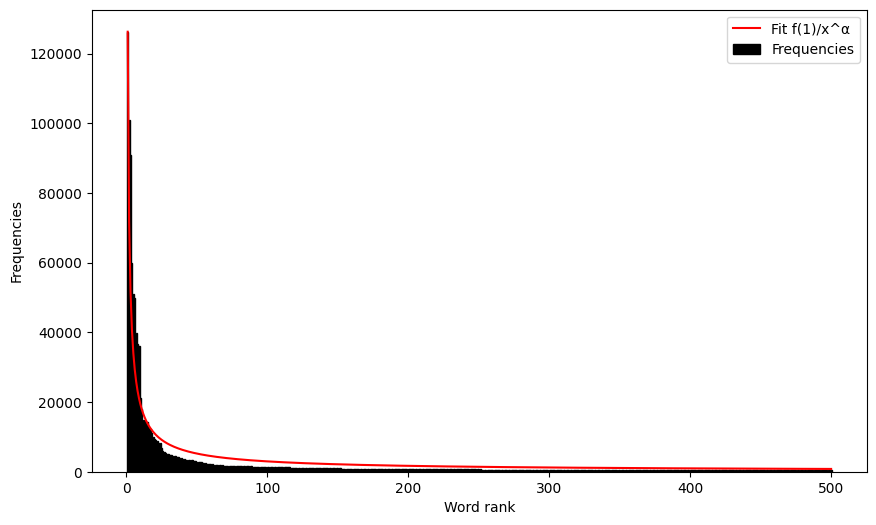

0.8145502363119796


In [41]:
def zipf(x, alpha):
    return 126301 / np.power(x, alpha)

# Define function to fit and plot with fit
def plot_histogram_with_fit(frequencies, fun):
    # Get indeces for x axis
    indices = np.arange(1, len(frequencies) + 1)

    # Fit
    popt, _ = curve_fit(fun, indices, frequencies)

    # Do histogram only plotting first 500 words
    plt.figure(figsize=(10, 6))
    plt.bar(indices[:500], frequencies[:500], color='black', edgecolor='black', label='Frequencies')

    # Add fit to the plot
    plt.plot(indices[:500], fun(indices, *popt)[:500], color='red', label='Fit f(1)/x^α')

    # Add more info to the plot
    plt.xlabel('Word rank')
    plt.ylabel('Frequencies')
    plt.legend()
    plt.show()

    # Print parameters
    print(*popt)
    
# Plot
plot_histogram_with_fit(sorted_freq, zipf)

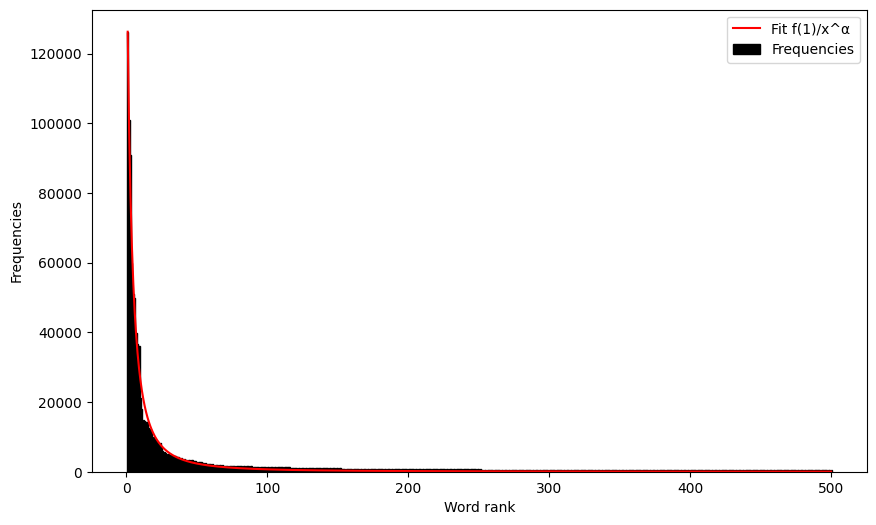

1.9492921860733383 6.296494432127077


In [42]:
def maldelbrot(x, alpha, beta):
    #126301 is the frequency of the most used word
    return 126301 * np.power(1 + beta, alpha) / np.power(x + beta, alpha)

plot_histogram_with_fit(sorted_freq, maldelbrot)
